# Summary
Here I'm going to look at historical fantasy football draft data and compare it to real performance that season.

In [1]:
# import
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# functions
def rank_to_points(adp_url,points_url):
    errors = []
    
    
    r = requests.get(adp_url)
    data_dict = r.json()
    # all players
    players = data_dict['players']

    # create dictionaries of each position
    QBs = {}
    RBs = {}
    WRs = {}
    TEs = {}

    # now here populate the dictionaries
    for player in players:
        name = player['name']
        ADP = player['adp_formatted']
        if player['position'] == 'QB':
            QBs[name] = ADP 
        elif player['position'] == 'RB':
            RBs[name] = ADP 
        elif player['position'] == 'WR':
            WRs[name] = ADP
        elif player['position'] == 'TE':
            TEs[name] = ADP

    try:
        QBs['Patrick Mahomes'] = QBs['Pat Mahomes']
        QBs.pop('Pat Mahomes', None)
    except KeyError:
        pass
    try:
        QBs['Mitchell Trubisky'] = QBs['Mitch Trubisky']
        QBs.pop('Mitch Trubisky', None)
    except KeyError:
        pass
    # Bell
    try:
        RBs['Le\'Veon Bell'] = RBs['LeVeon Bell']
        RBs.pop('LeVeon Bell', None)
    except KeyError:
        pass
    
    QBs = dict(sorted(QBs.items(), key=lambda item: float(item[1])))
    RBs = dict(sorted(RBs.items(), key=lambda item: float(item[1])))
    WRs = dict(sorted(WRs.items(), key=lambda item: float(item[1])))
    TEs = dict(sorted(TEs.items(), key=lambda item: float(item[1])))

    # lets convert the value to a rank, 1 2 3 etc.
    count = 1
    for name in QBs:
        QBs[name] = count
        count += 1

    # now for the rest
    count = 1
    for name in RBs:
        RBs[name] = count
        count += 1
    
    count = 1
    for name in WRs:
        WRs[name] = count
        count += 1
    
    count = 1
    for name in TEs:
        TEs[name] = count
        count += 1
  

    ######## now lets deal with points data
    df = pd.read_csv(points_url)
    df['fantasy_points'] = (df['PassingYds']*0.04 + df['PassingTD']*4 - df['Int']*2 + df['RushingYds']*0.1 + df['RushingTD']*6 +
                        df['Rec'] + df['ReceivingYds']*0.1 + df['ReceivingTD']*6 - df['FumblesLost']*2)
    aggregation_functions = {'Player': 'first', 'fantasy_points': 'sum'}
    df = df.groupby(df['Player']).aggregate(aggregation_functions)
    qb_rank = {}
    count = 1
    for qb in QBs:
        #print(qb)
        try:
            points = df['fantasy_points'][qb]
            rank = QBs[qb]
        except KeyError:
            errors.append(qb)
            print(qb)

        if points >= 10:
            qb_rank[count] = points
            count += 1
        

    # now for the rest, prepare for name errors...
    rb_rank = {}
    count = 1
    for rb in RBs:
        try:
            points = df['fantasy_points'][rb]
            rank = RBs[rb]
        except KeyError:
            errors.append(rb)
    
        if points >= 10:
            rb_rank[count] = points
            count += 1

    wr_rank = {}
    count = 1
    for wr in WRs:
        try:
            points = df['fantasy_points'][wr]
            rank = WRs[wr]
        except KeyError:
            errors.append(wr)
    
        if points >= 10:
            wr_rank[count] = points
            count += 1
    
    te_rank = {}
    count = 1
    for te in TEs:
        try:
            points = df['fantasy_points'][te]
            rank = TEs[te]
        except KeyError:
            errors.append(te)
    
        if points >= 10:
            te_rank[count] = points
            count += 1
        
    return qb_rank, rb_rank, wr_rank, te_rank, errors

###################################################################

def combine(sets):
    lengths = []
    for i in sets:
        lengths.append(len(i))
    min_length = min(lengths)
    max_length = max(lengths)
    #set_sum = np.zeros(min_length)
    set_sum = np.zeros(max_length)
    for s in sets:
        N = max_length - len(s)
        #array = np.array(list(s.values())[0:min_length])
        array = np.pad(np.array(list(s.values())), (0,N), 'constant')
        set_sum += array
    avg = set_sum / len(sets)
    avg = avg[:min_length]
    return avg

####################################################################

def smooth(data,window_width):
#window_width = 3
    cumsum_vec = np.cumsum(np.insert(data, 0, 0))
    #print(cumsum_vec)
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec

#####################################################################

def sort_descending(data):
    new = dict(sorted(data.items(), key=lambda item: -1*item[1]))
    return new

####################################################################

def standard_deviation(sets):
    lengths = []
    for i in sets:
        lengths.append(len(i))
    min_length = min(lengths)
    max_length = max(lengths)
    #set_sum = np.zeros(min_length)
    array_2d = np.empty((1,max_length))
    for s in sets:
        N = max_length - len(s)
        #array = np.array(list(s.values())[0:min_length])
        array = np.pad(np.array(list(s.values())), (0,N), 'constant')
        array_2d = np.append(array_2d, [array], axis=0)
        std = np.std(array_2d, axis=0)
    std = std[:min_length]  
    return std

In [3]:
# load data

url1 = 'https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year=2020'
url2 = 'data/2020.csv'
qb20,rb20,wr20,te20,error20 = rank_to_points(url1,url2)

url1 = 'https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year=2019'
url2 = 'data/2019.csv'
qb19,rb19,wr19,te19,error19 = rank_to_points(url1,url2)

url1 = 'https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year=2018'
url2 = 'data/2018.csv'
qb18,rb18,wr18,te18,error18 = rank_to_points(url1,url2)

url1 = 'https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year=2017'
url2 = 'data/2017.csv'
qb17,rb17,wr17,te17,error17 = rank_to_points(url1,url2)

url1 = 'https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year=2016'
url2 = 'data/2016.csv'
qb16,rb16,wr16,te16,error16 = rank_to_points(url1,url2)

url1 = 'https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year=2015'
url2 = 'data/2015.csv'
qb15,rb15,wr15,te15,error15 = rank_to_points(url1,url2)

url1 = 'https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year=2014'
url2 = 'data/2014.csv'
qb14,rb14,wr14,te14,error14 = rank_to_points(url1,url2)

url1 = 'https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year=2013'
url2 = 'data/2013.csv'
qb13,rb13,wr13,te13,error13 = rank_to_points(url1,url2)

url1 = 'https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year=2012'
url2 = 'data/2012.csv'
qb12,rb12,wr12,te12,error12 = rank_to_points(url1,url2)

url1 = 'https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year=2011'
url2 = 'data/2011.csv'
qb11,rb11,wr11,te11,error11 = rank_to_points(url1,url2)

url1 = 'https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year=2010'
url2 = 'data/2010.csv'
qb10,rb10,wr10,te10,error10 = rank_to_points(url1,url2)

In [5]:
# combine the data

qbs = [qb20, qb19, qb18, qb17, qb16, qb15, qb14, qb13, qb12, qb11, qb10]
rbs = [rb20, rb19, rb18, rb17, rb16, rb15, rb14, rb13, rb12, rb11, rb10]
wrs = [wr20, wr19, wr18, wr17, wr16, wr15, wr14, wr13, wr12, wr11, wr10]
tes = [te20,te19, te18, te17, te16, te15, te14, te13, te12, te11, te10]

qb_avg = combine(qbs)
rb_avg = combine(rbs)
wr_avg = combine(wrs)
te_avg = combine(tes)

In [6]:
# smooth the data

width = 3
qb_smooth = smooth(qb_avg, width)
rb_smooth = smooth(rb_avg, width)
wr_smooth = smooth(wr_avg, width)
te_smooth = smooth(te_avg, width)

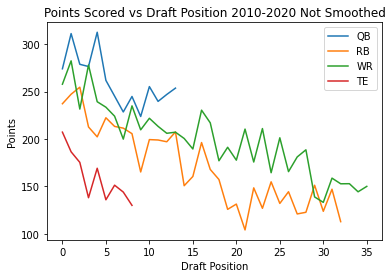

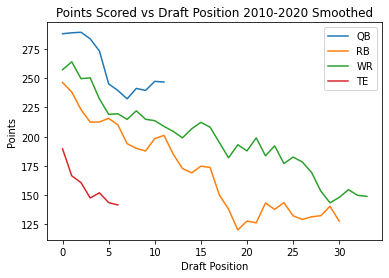

In [7]:
# plot so far

plt.plot(qb_avg, label='QB')
plt.plot(rb_avg, label='RB')
plt.plot(wr_avg, label='WR')
plt.plot(te_avg, label='TE')
plt.legend()
plt.xlabel('Draft Position')
plt.ylabel('Points')
plt.title('Points Scored vs Draft Position 2010-2020 Not Smoothed')
plt.show()

plt.plot(qb_smooth, label='QB')
plt.plot(rb_smooth, label='RB')
plt.plot(wr_smooth, label='WR')
plt.plot(te_smooth, label='TE')
plt.legend()
plt.xlabel('Draft Position')
plt.ylabel('Points')
plt.title('Points Scored vs Draft Position 2010-2020 Smoothed')
plt.show()

Here is the total points scored by each player, by draft rank within their own position. Next, we will get a better idea of how quickly points drop off within each position.

In [8]:
# rank all players, combining positions
qb_diff = qb_smooth - qb_smooth[11]
rb_diff = rb_smooth - rb_smooth[24]
wr_diff = wr_smooth - wr_smooth[24]
te_diff = te_smooth - te_smooth[6]

all_dict = {}
count = 1
for i in qb_diff:
    name = 'QB{}'.format(count)
    all_dict[name] = i
    count += 1
    
count = 1
for i in rb_diff:
    name = 'RB{}'.format(count)
    all_dict[name] = i
    count += 1
    
count = 1
for i in wr_diff:
    name = 'WR{}'.format(count)
    all_dict[name] = i
    count += 1
    
count = 1
for i in te_diff:
    name = 'TE{}'.format(count)
    all_dict[name] = i
    count += 1
    
draft_order = sort_descending(all_dict)

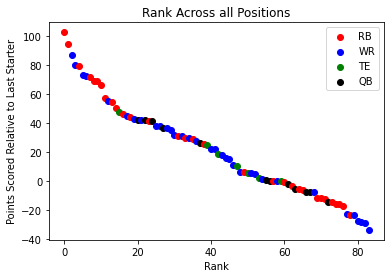

In [9]:
#count = 1
for count, player in enumerate(draft_order):
    points = draft_order[player]
    position = ''.join([i for i in player if not i.isdigit()])
    if position == 'QB':
        if player[2:] == '1':
            plt.scatter(count, points, label=position, color='k')
        else:
            plt.scatter(count, points, color='k')
        #count += 1
    if position == 'RB':
        if player[2:] == '1':
            plt.scatter(count, points, label=position, color='r')
        else:
            plt.scatter(count, points, color='r')
    if position == 'WR':
        if player[2:] == '1':
            plt.scatter(count, points, label=position, color='b')
        else:
            plt.scatter(count, points, color='b')
    if position == 'TE':
        if player[2:] == '1':
            plt.scatter(count, points, label=position, color='g')
        else:
            plt.scatter(count, points, color='g')

plt.legend()
#plt.xlim(0,150)
#plt.ylim(0,150)
plt.xlabel('Rank')
plt.ylabel('Points Scored Relative to Last Starter')
plt.title('Rank Across all Positions')
plt.show()       

This shows how much better each player is relative to the last "starter" in that league. We can see the point advantage gained by running backs and wide recievers.